# Transformer Architecture: A Complete Guide

## The Networking Event Story 🎉

This notebook captures our exploration of transformer architecture through an intuitive **networking event analogy**. Every component maps to a part of attending professional networking parties.

---

## Table of Contents

1. [Token & Positional Embeddings](#1-token--positional-embeddings)
2. [Self-Attention (Q, K, V)](#2-self-attention-q-k-v)
3. [Causal Masking](#3-causal-masking)
4. [Multi-Head Attention](#4-multi-head-attention)
5. [Layer Normalization](#5-layer-normalization)
6. [Feed-Forward Network (MLP)](#6-feed-forward-network-mlp)
7. [Residual Connections](#7-residual-connections)
8. [Transformer Block](#8-transformer-block)
9. [Ready-Made Options](#9-ready-made-options)
10. [Quick Reference](#10-quick-reference)

---

## 1. Token & Positional Embeddings

### The Problem
How does a transformer convert raw token indices into meaningful vectors that also know their position in a sequence?

### The Solution
Two embedding lookup tables, **added together**:
1. **Token embedding** — maps each word to a learned vector (what the word *means*)
2. **Positional embedding** — maps each position to a learned vector (where the word *sits*)

> **🎯 Sticky Analogy:** Imagine name tags at a dinner party. The token embedding is your *name*, the positional embedding is your *seat number*. Combined, everyone knows both who you are and where you're sitting.

### Key Insight
- Embeddings are just **learnable lookup tables** (matrices)
- Token + position embeddings are **added**, not concatenated
- This combined vector is what enters the transformer layers

### GPT-2 vs Our Toy Model

| | Toy Model | GPT-2 |
|---|-----------|-------|
| Token embedding | (5, 3) | (50257, 768) |
| Position embedding | (10, 3) | (1024, 768) |
| Vocab size | 5 words | 50,257 tokens |
| Max sequence | 10 | 1,024 |

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Token embedding: what each word means
vocab_size, embed_dim = 5, 3
embedding = nn.Embedding(vocab_size, embed_dim)

# Position embedding: where each word sits
max_seq_len = 10
pos_embedding = nn.Embedding(max_seq_len, embed_dim)

# "cat sat on mat" → indices [0, 2, 3, 4]
sentence = torch.tensor([0, 2, 3, 4])
positions = torch.tensor([0, 1, 2, 3])

# Combined: token + position (element-wise addition)
combined = embedding(sentence) + pos_embedding(positions)
print(f"Combined shape: {combined.shape}")  # (4, 3)

Combined shape: torch.Size([4, 3])


---

## 2. Self-Attention (Q, K, V)

### The Problem
How can each word in a sentence learn from other relevant words to understand context?

### The Solution
Self-attention mechanism with **Q, K, V projections**:
- **Q (Query)** — "What am I looking for?"
- **K (Key)** — "What do I advertise?"
- **V (Value)** — "What can I share?"

> **🎯 Sticky Analogy: The Q/K/V Dance**
> 
> Imagine a networking party:
> - **Q**: "Who should I talk to?" (asking questions)
> - **K**: "Here's my business card" (showing name tags)
> - **V**: "Here's my expertise to share" (sharing info)
> 
> Everyone does the Q/K/V dance with everyone else!

### The Flow
1. Compute scores: `Q @ K.T` → "Who is relevant to me?"
2. Softmax → Convert to percentages (attention weights)
3. Weighted sum: `attn_weights @ V` → Absorb information from relevant words

### Key Concept: Learned Projections
Q, K, V are **not** raw embeddings — they're transformed by **learned projection matrices** (W_q, W_k, W_v). Through training:
- W_q learns: "Given my embedding, what should I **look for**?"
- W_k learns: "Given my embedding, what should I **advertise**?"
- W_v learns: "Given my embedding, what should I **share**?"

> **💡 Key Insight:** Words start **isolated** (can't talk to each other). After attention, each word has **absorbed context** from relevant words, producing a **new representation**.

In [ ]:
# Q, K, V projections (learned during training)
d_model = 3
W_q = nn.Linear(d_model, d_model, bias=False)
W_k = nn.Linear(d_model, d_model, bias=False)
W_v = nn.Linear(d_model, d_model, bias=False)

Q = W_q(combined)
K = W_k(combined)
V = W_v(combined)

# Attention scores: "How relevant is each word to each other?"
scores = Q @ K.T  # (4, 4)

# Convert to percentages
attn_weights = F.softmax(scores, dim=-1)

# New representation: absorb information from others
output = attn_weights @ V
print(f"Attention weights shape: {attn_weights.shape}")  # (4, 4)
print(f"Output shape: {output.shape}")  # (4, 3)

Attention weights shape: torch.Size([4, 4])
Output shape: torch.Size([4, 3])


---

## 3. Causal Masking

### The Problem
In language generation, words shouldn't peek at future words. How do we prevent this?

### The Solution
Apply a **lower-triangular mask** before softmax:
1. Create mask: `torch.tril(torch.ones(seq_len, seq_len))`
2. Set future positions to `-inf`: `scores.masked_fill(mask == 0, float('-inf'))`
3. Softmax converts `-inf` → 0% attention

> **🎯 Sticky Analogy:** It's like reading a mystery novel — you can remember what you've already read (past tokens), but you can't flip ahead to see who the killer is (future tokens).

### The Mask Pattern

| | cat | sat | on | mat |
|---|---|---|---|---|
| **cat** | ✓ | ✗ | ✗ | ✗ |
| **sat** | ✓ | ✓ | ✗ | ✗ |
| **on** | ✓ | ✓ | ✓ | ✗ |
| **mat** | ✓ | ✓ | ✓ | ✓ |

In [ ]:
# Create causal mask (lower triangular)
mask = torch.tril(torch.ones(4, 4))

# Apply mask: future positions → -inf
scores_masked = scores.masked_fill(mask == 0, float('-inf'))

# Softmax: -inf becomes 0%
attn_weights_causal = F.softmax(scores_masked, dim=-1)

# Now words can only attend to past + self
output_causal = attn_weights_causal @ V

---

## 4. Multi-Head Attention

### The Problem
Single-head attention produces only **one attention pattern** — it can focus on one type of relationship at a time. But language has multiple simultaneous relationships (grammar, coreference, semantics, etc.).

### The Solution
Split the embedding into **multiple heads**, each running its own attention in parallel:
- 768 dims ÷ 12 heads = 64 dims per head
- Each head learns different relationships
- Concatenate outputs back to 768 dims

> **🎯 Sticky Analogy:** 12 detectives investigating the same crime scene. Each has a specialty (fingerprints, timelines, witness relationships). They work **in parallel** and combine their findings into one complete report.

### Key Term: **Expressiveness**
Multi-head attention gives the model more **expressiveness** — the ability to capture multiple types of relationships simultaneously.

### Heads vs Layers

| | Multi-Head | Layers |
|---|-----------|--------|
| **What** | 12 heads | 12 blocks |
| **Direction** | Parallel (side by side) | Sequential (one after another) |
| **Purpose** | Expressiveness — different perspectives at once | Depth — build understanding layer by layer |
| **Analogy** | 12 conversations at the **same** party | 12 **different** parties over time |

In [ ]:
# Using PyTorch's Multi-Head Attention
mha = nn.MultiheadAttention(embed_dim=3, num_heads=3, batch_first=True)

# Add batch dimension
x_batched = combined.unsqueeze(0)  # (4, 3) → (1, 4, 3)

# Causal mask for PyTorch
attn_mask = torch.triu(torch.ones(4, 4), diagonal=1).bool()

# Self-attention: pass x three times (Q, K, V all same)
output, attn_weights = mha(x_batched, x_batched, x_batched, attn_mask=attn_mask)

print(f"Input: {x_batched.shape}")       # (1, 4, 3)
print(f"Output: {output.shape}")          # (1, 4, 3)
print(f"Attention: {attn_weights.shape}") # (1, 4, 4)

Input: torch.Size([1, 4, 3])
Output: torch.Size([1, 4, 3])
Attention: torch.Size([1, 4, 4])


### The Attention Dance (Complete Code with Analogies)

In [ ]:
# THE ATTENTION DANCE 💃

# 4 people at a party, each with a 6-number ID card
people_at_party = combined.unsqueeze(0)  # (1, 4, 3) = (1 party, 4 people, 3-number ID)

# The dance floor (3 heads = 3 different conversations)
dance_floor = nn.MultiheadAttention(embed_dim=3, num_heads=3, batch_first=True)

# Causal mask: can only talk to people you've already met (no peeking ahead!)
no_peeking = torch.triu(torch.ones(4, 4), diagonal=1).bool()

# Everyone does the Q/K/V dance with everyone else (self-attention)
# Q: "Who should I talk to?"  K: "Here's my name tag"  V: "Here's what I'll share"
new_representation, who_talked_to_whom = dance_floor(
    people_at_party,  # Q - asking questions
    people_at_party,  # K - showing name tags  
    people_at_party,  # V - sharing info
    attn_mask=no_peeking
)

print(f"Before dance (isolated): {people_at_party.shape}")
print(f"After dance (absorbed context): {new_representation.shape}")

Before dance (isolated): torch.Size([1, 4, 3])
After dance (absorbed context): torch.Size([1, 4, 3])


---

## 5. Layer Normalization

### The Problem
After attention, some values might be very large ("shouting") and some very small ("whispering"). This makes training unstable.

### The Solution
Normalize each vector to have **mean=0** and **std=1**.

> **🎯 Sticky Analogy:** The **sound engineer** at the party — adjusts everyone's volume so they're all speaking at a similar level.

### What LayerNorm Does
1. **Centers** the values → mean becomes 0
2. **Scales** the values → std becomes 1

Also has learnable parameters (gamma, beta) for fine-tuning.

In [ ]:
# The sound engineer — normalizes across the embedding dimension
sound_engineer = nn.LayerNorm(3)

# Before: chaotic volumes
print("Before LayerNorm:")
print(new_representation[0])

# After: balanced volumes
normalized = sound_engineer(new_representation)
print("\nAfter LayerNorm:")
print(normalized[0])

# Each person now has mean≈0, std≈1
print(f"\nPer-person mean: {normalized[0].mean(dim=-1).detach()}")
print(f"Per-person std:  {normalized[0].std(dim=-1).detach()}")

Before LayerNorm:
tensor([[ 0.5131,  0.5449,  0.3283],
        [ 0.4041,  0.9956,  0.4095],
        [-0.1467, -0.8052, -0.4480],
        [ 0.6005,  0.5295,  0.0015]], grad_fn=<SelectBackward0>)

After LayerNorm:
tensor([[ 0.5334,  0.8669, -1.4003],
        [-0.7169,  1.4141, -0.6971],
        [ 1.1885, -1.2579,  0.0694],
        [ 0.8358,  0.5700, -1.4058]], grad_fn=<SelectBackward0>)

Per-person mean: tensor([ 0.0000e+00, -1.9868e-08, -6.4572e-08, -3.9736e-08])
Per-person std:  tensor([1.2241, 1.2247, 1.2247, 1.2247])


---

## 6. Feed-Forward Network (MLP)

### The Problem
After attention, each person has absorbed contacts. But raw contacts aren't enough — they need to **process and reflect** on what they learned.

### The Solution
**Expand then compress**: think deeply, extract key insights.
- Expand: 768 → 3072 (4× larger)
- Activation: GELU ("aha moments")
- Compress: 3072 → 768 (back to original)

> **🎯 Sticky Analogy:** Going home and **journaling** after the party. First you expand your thoughts (think deeply, explore ideas), then you compress back to key insights.

### Why GELU?
- **ReLU**: Hard cutoff at 0. Anything negative → 0. Harsh.
- **GELU**: Smooth curve. Small negatives get partially kept. Better gradient flow.

In [ ]:
# After the party, time to reflect and process (MLP)
expand_thoughts = nn.Linear(3, 12)   # Think deeply (3 → 12, i.e., 4×)
compress_insights = nn.Linear(12, 3) # Key insights (12 → 3)

reflected = expand_thoughts(normalized)
print(f"Expanded thoughts: {reflected.shape}")  # (1, 4, 12)

reflected = F.gelu(reflected)  # Activation: "aha moments"

reflected = compress_insights(reflected)
print(f"Compressed insights: {reflected.shape}")  # (1, 4, 3)

Expanded thoughts: torch.Size([1, 4, 12])
Compressed insights: torch.Size([1, 4, 3])


---

## 7. Residual Connections

### The Problem
After reflecting in your journal (MLP), you now have "processed insights." But what if you overthink and **forget who you originally were**?

### The Solution
Keep your original identity while adding the new stuff:

```python
output = original + processed
```

> **🎯 Sticky Analogy:** Keep your original **ID card** while adding new learnings on top. **Don't forget yourself!** Even after many rounds of parties (transformer layers), you retain your core identity.

In [ ]:
# Residual connection: keep your original identity
original = normalized
processed = reflected

# Don't lose yourself! Original + new learning
final = original + processed
print(f"Original: {original.shape}")
print(f"Final (original + learning): {final.shape}")

Original: torch.Size([1, 4, 3])
Final (original + learning): torch.Size([1, 4, 3])


---

## 8. Transformer Block

### The Complete Networking Event

One Transformer Block = One complete networking event cycle:

1. **Arrive at party** → Input embeddings
2. **Mingle & dance** → Multi-Head Attention (Q/K/V dance)
3. **Don't forget yourself** → Residual connection
4. **Sound engineer** → LayerNorm
5. **Go home & journal** → MLP (expand → aha → compress)
6. **Don't forget yourself again** → Residual connection
7. **Sound engineer again** → LayerNorm

### GPT-2 Architecture
- **12 layers** (sequential) — 12 different parties over time
- **12 heads per layer** (parallel) — 12 conversations at each party
- Total: 12 × 12 = **144 attention patterns**!

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads, mlp_ratio=4):
        super().__init__()
        # The dance floor (multi-head attention)
        self.attention = nn.MultiheadAttention(embed_dim, n_heads, batch_first=True)
        
        # Sound engineers (layer norms)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        
        # Journaling room (MLP: expand → aha → compress)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),  # Expand thoughts
            nn.GELU(),                                     # Aha moments
            nn.Linear(embed_dim * mlp_ratio, embed_dim)   # Compress insights
        )
    
    def forward(self, x, mask=None):
        # 1. Attention dance + don't forget yourself (residual)
        attn_out, _ = self.attention(x, x, x, attn_mask=mask)
        x = self.ln1(x + attn_out)  # Residual + sound engineer
        
        # 2. Journaling + don't forget yourself (residual)
        mlp_out = self.mlp(x)
        x = self.ln2(x + mlp_out)   # Residual + sound engineer
        
        return x

# Test it
block = TransformerBlock(embed_dim=3, n_heads=3)
causal_mask = torch.triu(torch.ones(4, 4), diagonal=1).bool()
output = block(people_at_party, mask=causal_mask)
print(f"Input: {people_at_party.shape}")
print(f"Output: {output.shape}")

Input: torch.Size([1, 4, 3])
Output: torch.Size([1, 4, 3])


---

## 9. Ready-Made Options

### Three Ways to Build Transformers

| Approach | Use Case | Analogy |
|----------|----------|--------|
| **Build from scratch** | Learning, research | Learning how engines work |
| **PyTorch built-in** | Custom architectures | Buying engine parts, assembling yourself |
| **HuggingFace** | Production apps | Buying a complete car, ready to drive |

In [ ]:
# Option 1: Our custom block (what we built)
block = TransformerBlock(embed_dim=3, n_heads=3)

# Option 2: PyTorch ready-made
decoder_layer = nn.TransformerDecoderLayer(
    d_model=3, 
    nhead=3, 
    dim_feedforward=12, 
    batch_first=True
)

# Option 3: HuggingFace (full GPT-2, pre-trained!)
from transformers import GPT2LMHeadModel, GPT2Tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Tokenize text
text = "cat sat on mat"
tokens = tokenizer(text, return_tensors='pt')
print(f"Text: {text}")
print(f"Token IDs: {tokens['input_ids']}")

Text: cat sat on mat
Token IDs: tensor([[9246, 3332,  319, 2603]])


---

## 10. Quick Reference

### The Complete Networking Event Story

| Component | Analogy | What it does |
|-----------|---------|-------------|
| Token Embedding | ID card (who you are) | Maps words → vectors |
| Position Embedding | Seat number | Encodes word order |
| Multi-Head Attention | Q/K/V dance at the party | Words absorb context from each other |
| Causal Mask | No peeking ahead (mystery novel) | Can only see past tokens |
| LayerNorm | Sound engineer | Balance volumes (mean=0, std=1) |
| MLP | Journaling at home | Expand → aha → compress insights |
| Residual Connection | Don't forget yourself | Original + learning |
| Transformer Block | One networking event | Attention + MLP + residuals |
| 12 Layers | 12 parties over time | Deeper understanding |
| 12 Heads | 12 conversations at same party | Expressiveness |

### GPT-2 Architecture Numbers

| Parameter | GPT-2 Small | GPT-2 Medium | GPT-2 Large |
|-----------|-------------|--------------|-------------|
| Layers | 12 | 24 | 36 |
| Heads | 12 | 16 | 20 |
| Embed dim | 768 | 1024 | 1280 |
| Vocab size | 50,257 | 50,257 | 50,257 |
| Max seq len | 1,024 | 1,024 | 1,024 |

### Key Formulas

**Self-Attention:**
\[
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\]

**Layer Normalization:**
\[
\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sigma} + \beta
\]

**Residual Connection:**
\[
\text{output} = x + \text{SubLayer}(x)
\]

### Tensor Shapes Cheatsheet

| Tensor | Shape | Description |
|--------|-------|-------------|
| Input tokens | (batch, seq_len) | Token indices |
| Embeddings | (batch, seq_len, embed_dim) | After token + position |
| Q, K, V | (batch, seq_len, embed_dim) | Projections |
| Attention weights | (batch, seq_len, seq_len) | Who attends to whom |
| Output | (batch, seq_len, embed_dim) | New representation |

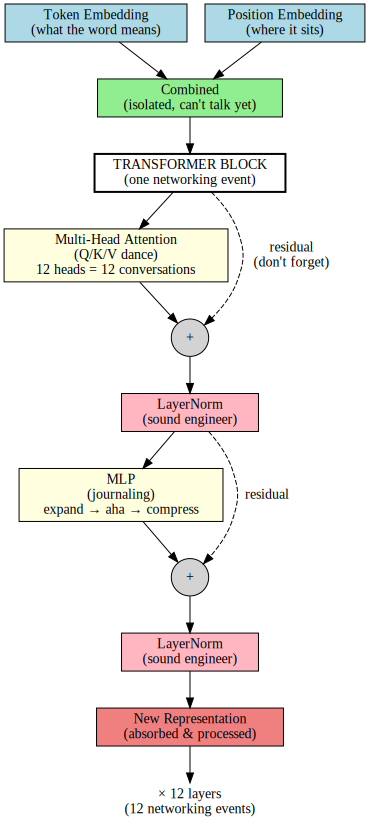

In [ ]:
from graphviz import Digraph

dot = Digraph(comment='Transformer Block - Complete')
dot.attr(rankdir='TB', size='10,14')

# Input
dot.node('tok', 'Token Embedding\n(what the word means)', shape='box', style='filled', fillcolor='lightblue')
dot.node('pos', 'Position Embedding\n(where it sits)', shape='box', style='filled', fillcolor='lightblue')
dot.node('combined', 'Combined\n(isolated, can\'t talk yet)', shape='box', style='filled', fillcolor='lightgreen')

# Transformer Block
dot.node('block_start', 'TRANSFORMER BLOCK\n(one networking event)', shape='box', style='filled,bold', fillcolor='white')

# Attention + residual
dot.node('mha', 'Multi-Head Attention\n(Q/K/V dance)\n12 heads = 12 conversations', shape='box', style='filled', fillcolor='lightyellow')
dot.node('res1', '+', shape='circle', style='filled', fillcolor='lightgray')
dot.node('ln1', 'LayerNorm\n(sound engineer)', shape='box', style='filled', fillcolor='lightpink')

# MLP + residual
dot.node('mlp', 'MLP\n(journaling)\nexpand → aha → compress', shape='box', style='filled', fillcolor='lightyellow')
dot.node('res2', '+', shape='circle', style='filled', fillcolor='lightgray')
dot.node('ln2', 'LayerNorm\n(sound engineer)', shape='box', style='filled', fillcolor='lightpink')

# Output
dot.node('output', 'New Representation\n(absorbed & processed)', shape='box', style='filled', fillcolor='lightcoral')
dot.node('repeat', '× 12 layers\n(12 networking events)', shape='plaintext')

# Edges
dot.edge('tok', 'combined')
dot.edge('pos', 'combined')
dot.edge('combined', 'block_start')
dot.edge('block_start', 'mha')
dot.edge('mha', 'res1')
dot.edge('block_start', 'res1', style='dashed', label='residual\n(don\'t forget)')
dot.edge('res1', 'ln1')
dot.edge('ln1', 'mlp')
dot.edge('mlp', 'res2')
dot.edge('ln1', 'res2', style='dashed', label='residual')
dot.edge('res2', 'ln2')
dot.edge('ln2', 'output')
dot.edge('output', 'repeat')

dot


---

## 🎯 TL;DR Summary

A transformer is like attending **12 networking parties** (layers):

1. **Arrive** with your ID card (token + position embedding)
2. **Dance** with everyone (multi-head attention with Q/K/V)
3. **Absorb** knowledge from relevant people (attention weights × V)
4. **Balance** your energy (LayerNorm)
5. **Journal** at home (MLP: expand → aha → compress)
6. **Don't forget** who you are (residual connections)
7. **Repeat** 12 times for deep understanding

After 12 parties, you're a networking pro with rich, layered understanding of the world! 🎉

In [ ]:
#| hide

import subprocess
from pathlib import Path
from dialoghelper import curr_dialog

def deploy_notebook():
    nb_name = Path(curr_dialog()['name']).name + '.ipynb'
    src = f'/app/data/{curr_dialog()["name"]}.ipynb'
    dst = '/app/data/publish/portfolio/static/'
    print(nb_name)
    
    # Copy notebook to static folder
    subprocess.run(['cp', src, dst])
    
    # Deploy with plash
    subprocess.run(['plash_deploy'], cwd='/app/data/publish/portfolio')

In [ ]:
#| hide

In [ ]:
#| hide
deploy_notebook()